# Task Overview

Your task will be to implement a *RevNet* (Reversible Residual Network) – a variant of ResNet where each layer's activations can be reconstructed exactly from the next layer. Therefore, the activations for most layers need not be stored in memory to perform backpropagation.

You can find more information about RevNet here: [link](https://arxiv.org/pdf/1707.04585.pdf)

You should use an MLP architecture trained on the MNIST dataset. You should implement the network in numpy.

Tasks:
1. (10pt) Fill missing code below
  - 1pt implement the `__init__` method
  - 2pt implement the feedforward method
  - 2pt implement the mini-batch update
  - 5pt implement the backpropagation (note: if you implement backpropagation example-by-example instead of whole minibatch at once, you will get maximum of 2pt for this part)
2. Train the models (find proper hyperparameters). Visualize training of your best model (plot training and test loss/accuracy in time). Your model should reach at least 96% accuracy. Use clear ml for logging your scores. Make a comparison of memory usage for your network and the network you implemented in lab 3.
  - 1pt for accuracy above 96%
  - 1pt for visualizations (we recommend downloading plots from clear ml)
  - 2pt if [clear ml](https://clear.ml/docs/latest/docs/) used properly
  - 1pt for comparing memory usage.



## Potential questions, clarifications
- Q: Can I save the output of the last layer before classification (a -> 10)?
  - Yes.
- Q: MNIST has only one channel, how do I split that into two groups for implementing ReVNet blocks?
  - You can split activations into two groups, so if a layer has size $a$ you can split it into $2 \cdot a/2$.
- Q: Can I modify code of ReVNet outside #Your code goes here # to include logging?
  - Yes, in ReVNet.SGD

# Imports

In [19]:
!pip install clearml --quiet
!pip install memory-profiler --quiet


In [49]:
import random
import numpy as np
from torchvision import datasets, transforms
from clearml import Task
import plotly.express as px
import matplotlib.pyplot as plt

In [4]:
%load_ext memory_profiler

# Dataset loading


In [5]:
!wget -O mnist.npz https://s3.amazonaws.com/img-datasets/mnist.npz

--2023-11-27 02:58:21--  https://s3.amazonaws.com/img-datasets/mnist.npz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.125.64, 54.231.137.232, 52.217.89.30, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.125.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11490434 (11M) [application/octet-stream]
Saving to: ‘mnist.npz’

mnist.npz           100%[===================>]  10.96M  13.8MB/s    in 0.8s    

2023-11-27 02:58:22 (13.8 MB/s) - ‘mnist.npz’ saved [11490434/11490434]



In [6]:
def load_mnist(path='mnist.npz'):
    with np.load(path) as f:
        x_train, _y_train = f['x_train'], f['y_train']
        x_test, _y_test = f['x_test'], f['y_test']

    x_train = x_train.reshape(-1, 28 * 28) / 255.
    x_test = x_test.reshape(-1, 28 * 28) / 255.

    y_train = np.zeros((_y_train.shape[0], 10))
    y_train[np.arange(_y_train.shape[0]), _y_train] = 1

    y_test = np.zeros((_y_test.shape[0], 10))
    y_test[np.arange(_y_test.shape[0]), _y_test] = 1

    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_mnist()

# Set up clear ml

In [ ]:
%env CLEARML_WEB_HOST=https://app.clear.ml
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
#%env CLEARML_API_ACCESS_KEY=
#%env CLEARML_API_SECRET_KEY=

In [ ]:
# best experiment: 4829a0f428d24f4aace76214ea56343e
# net with 1 rev blocks of 200 channels, each with 1-layer residual networks
# after 50 epochs with lr~0.1 it achieved 73% accuracy

# 2nd best experiment: 2649edba8f2d408baa3e7146516f4860
# net with 5 rev blocks of 20 channels, each with 2-layer residual networks
# after 200 epochs with lr~0.1 it achieved 66% accuracy

# Network definition (as in laboratory 3)


In [8]:
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    # Derivative of the sigmoid
    return sigmoid(z)*(1-sigmoid(z))

class Network(object):
    def __init__(self, sizes):
        # initialize biases and weights with random normal distr.
        # weights are indexed by target node first
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]
    def feedforward(self, a):
        # Run the network on a batch
        a = a.T
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.matmul(w, a)+b)
        return a

    def update_mini_batch(self, mini_batch, eta):
        # Update networks weights and biases by applying a single step
        # of gradient descent using backpropagation to compute the gradient.
        # The gradient is computed for a mini_batch which is as in tensorflow API.
        # eta is the learning rate
        nabla_b, nabla_w = self.backprop(mini_batch[0].T,mini_batch[1].T)

        self.weights = [w-(eta/len(mini_batch[0]))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch[0]))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        # For a single input (x,y) return a pair of lists.
        # First contains gradients over biases, second over weights.
        g = x
        gs = [g] # list to store all the gs, layer by layer
        fs = [] # list to store all the fs, layer by layer
        for b, w in zip(self.biases, self.weights):
            f = np.dot(w, g)+b
            fs.append(f)
            g = sigmoid(f)
            gs.append(g)
        # backward pass <- both steps at once
        dLdg = self.cost_derivative(gs[-1], y)
        dLdfs = []
        for w,g in reversed(list(zip(self.weights,gs[1:]))):
            dLdf = np.multiply(dLdg,np.multiply(g,1-g))
            dLdfs.append(dLdf)
            dLdg = np.matmul(w.T, dLdf)

        dLdWs = [np.matmul(dLdf,g.T) for dLdf,g in zip(reversed(dLdfs),gs[:-1])]
        dLdBs = [np.sum(dLdf,axis=1).reshape(dLdf.shape[0],1) for dLdf in reversed(dLdfs)]
        return (dLdBs,dLdWs)

    def evaluate(self, test_data):
        # Count the number of correct answers for test_data
        pred = np.argmax(self.feedforward(test_data[0]),axis=0)
        corr = np.argmax(test_data[1],axis=0)
        return np.mean(pred==corr)

    def cost_derivative(self, output_activations, y):
        return (output_activations-y)

    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None):
        x_train, y_train = training_data
        if test_data:
            x_test, y_test = test_data
        for j in range(epochs):
            for i in range(x_train.shape[0] // mini_batch_size):
                x_mini_batch = x_train[(mini_batch_size*i):(mini_batch_size*(i+1))]
                y_mini_batch = y_train[(mini_batch_size*i):(mini_batch_size*(i+1))]
                self.update_mini_batch((x_mini_batch, y_mini_batch), eta)
            if test_data:
                print("Epoch: {0}, Accuracy: {1}".format(j, self.evaluate((x_test.T, y_test.T))))
            else:
                print("Epoch: {0}".format(j))


# ReVNet definition

RevNets are composed of a series of reversible blocks. The channels (in case of MNIST: activations) in each layer are partitioned into two groups (two vectors), denoted $x_1$ and $x_2$.

Forward: Each reversible block takes inputs ($x_1$, $x_2$) and produces outputs produces outputs ($y_1$, $y_2$) using functions F and G (the *residuals*). In this task, implement F and G as MLP layers.

$z_1 = x_1 + \mathcal{F}(x_2)$

$y_2 = x_2 + \mathcal{G}(z_1)$

$y_1 = z_1$

The expressions $y_1$ and $z_1$ have the same value, but they are separate nodes in the computation graph, with $y_2$ depending on $z_1$, not $y_1$. We use this distinction so that we can describe gradient computations in two steps: $∂ℒ/∂y_1$ is the derivative of the loss over $y_1$ when $y_2$ is a fixed constant, while $∂ℒ/∂z_1$ is the derivative over $z_1$, which influences the loss through both y1 and y2.

Reverse: Each layer’s activations can be reconstructed from the next layer’s activations as follows:

$x_2 = y_2 - \mathcal{G}(y_1)$

$x_1 = y_1 - \mathcal{F}(x_2)$

Backpropagation is described in the algorithm below, ($y_1$, $y_2$).
$\bar{y_1}$, $\bar{y_2}$ is the gradient of the loss over $y_1$ and $y_2$, respectively


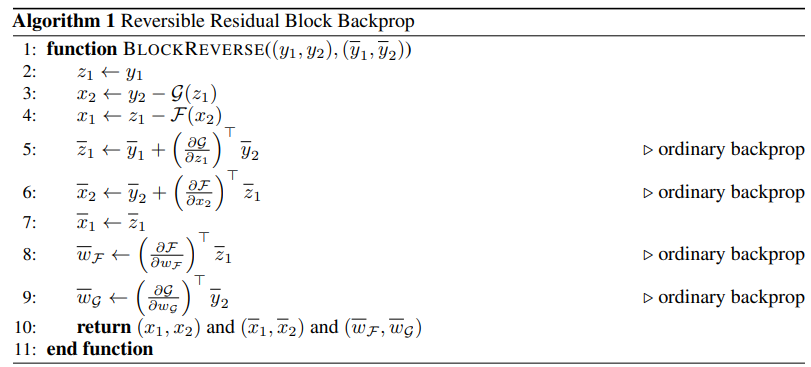

#I implemented two versions depending on the residual networks type: either 2 layers or 1

#Double-Layer residuals:

In [94]:
def rev_block_initialization(size_of_rev_block):
    size_of_residual = size_of_rev_block // 2

    biases_F1 = np.random.randn(size_of_residual, 1)
    weights_F1 = np.random.randn(size_of_residual, size_of_residual)

    biases_G1 = np.random.randn(size_of_residual, 1)
    weights_G1 = np.random.randn(size_of_residual, size_of_residual)

    biases_F2 = np.random.randn(size_of_residual, 1)
    weights_F2 = np.random.randn(size_of_residual, size_of_residual)

    biases_G2 = np.random.randn(size_of_residual, 1)
    weights_G2 = np.random.randn(size_of_residual, size_of_residual)

    return (biases_F1, weights_F1,  biases_G1, weights_G1,  biases_F2, weights_F2,  biases_G2, weights_G2)


def feedforward_through_rev_block(parameters, x1, x2):
    (biases_F1, weights_F1,  biases_G1, weights_G1,  biases_F2, weights_F2,  biases_G2, weights_G2) = parameters
    F1_x2 = sigmoid(np.matmul(weights_F1, x2) + biases_F1)
    F_x2 = sigmoid(np.matmul(weights_F2, F1_x2) + biases_F2)
    y1 = x1 + F_x2

    G1_y1 = sigmoid(np.matmul(weights_G1, y1) + biases_G1)
    G_y1 = sigmoid(np.matmul(weights_G2, G1_y1) + biases_G2)
    y2 = x2 + G_y1

    return (y1, y2)


def softmax(x):
    x = np.exp(x)
    x = x / np.sum(x, axis=0)
    return x


def cross_entropy(x, y):
    # y is true result
    #returns a vector of entries corresponding to examples
    epsilon = np.finfo(x.dtype).eps
    return np.sum(np.multiply(y, np.log(x + epsilon)), axis=0)


class RevNet2(object):
  def __init__(self, size_of_rev_block, number_of_rev_blocks, logger = None):
    self.logger = logger
    self.size_of_rev_block = size_of_rev_block
    self.number_of_rev_blocks = number_of_rev_blocks
    self.mnist_size = 28 * 28
    # initialize biases and weights with random normal distr.
    # weights are indexed by target node first

    # network is of the form - that is subsequent numbers of channels:
    # (mnist_size, a_1, a_2, a_3, ...,  a_n, 10),
    # where a_i for i in [1, 2, ..., n] is equal to the size_of_rev_block,
    # and n is the (number_of_rev_blocks + 1)
    # so that there are number_of_rev_blocks reversible blocks,
    # as defined in the paper, with size_of_rev_block channels
    # there are 2 ordinary fully connected layers:
    # at the beggining (mnist_size, size_of_rev_block)
    # and at the end (size_of_rev_block, 10)
    # IMPORTANT: number_of_rev_blocks >= 1
    # IMPORTANT: for simplicity size_of_rev_block is even
    # As the basic residual functions described in the
    # Deep Residual Learning for Image Recognition paper
    # functions F and G in reversible blocks are 2 layer networks,
    # here they are fully connected (instead of convolutional)
    ### Your code goes here ###

    self.biases_first_layer = np.random.randn(size_of_rev_block, 1)
    self.biases_last_layer = np.random.randn(10, 1)
    self.weights_first_layer = np.random.randn(size_of_rev_block, self.mnist_size)
    self.weights_last_layer = np.random.randn(10, size_of_rev_block)

    self.rev_blocks = [list(rev_block_initialization(size_of_rev_block)) for _ in range(number_of_rev_blocks)]
    ###########################

  def feedforward(self, a): #examples in columns
    # Run the network
    a = sigmoid(np.matmul(self.weights_first_layer, a) + self.biases_first_layer)
    middle = self.size_of_rev_block // 2
    x1 = a[ : middle]
    x2 = a[middle : ]
    for parameters in self.rev_blocks:
      (x1, x2) = feedforward_through_rev_block(parameters, x1, x2)
    a = np.concatenate((x1, x2))
    a = np.matmul(self.weights_last_layer, a) + self.biases_last_layer
    return softmax(a)


  def update_mini_batch(self, x_mini_batch, y_mini_batch, lr):
    # Update networks weights and biases by applying a single step
    # of gradient descent using backpropagation to compute the gradient.
    # The gradient is computed for a mini_batch.
    # lr is the learning rate
    eta = lr/len(x_mini_batch)
    # weights updates are computed inside the backprop
    # so as not to use additional memory unnecesarrily
    self.backpropagation(x_mini_batch.T, y_mini_batch.T, eta)


  def backprop_for_rev_block(self, nr, y1, y2, y1_deriv, y2_deriv, eta):
    (biases_F1, weights_F1,  biases_G1, weights_G1,  biases_F2, weights_F2,  biases_G2, weights_G2) = self.rev_blocks[nr]

    z1 = y1 #(size_of_rev_block/2, batch_size)
    G1_z1 = sigmoid(np.matmul(weights_G1, z1) + biases_G1) #(size_of_rev_block/2, batch_size)
    G_z1 = sigmoid(np.matmul(weights_G2, G1_z1) + biases_G2) #(size_of_rev_block/2, batch_size)

    x2 = y2 - G_z1 #(size_of_rev_block/2, batch_size)
    F1_x2 = sigmoid(np.matmul(weights_F1, x2) + biases_F1) #(size_of_rev_block/2, batch_size)
    F_x2 = sigmoid(np.matmul(weights_F2, F1_x2) + biases_F2) #(size_of_rev_block/2, batch_size)

    x1 = z1 - F_x2 #(size_of_rev_block/2, batch_size)
    #derivatives:
    #backprop for net G:
    #layer2:
    f2_G_deriv = np.multiply(y2_deriv, np.multiply(G_z1, 1 - G_z1))
    # for batches summing up happens automagically:
    self.rev_blocks[nr][5] -= np.matmul(f2_G_deriv, G1_z1.T) * eta
    self.rev_blocks[nr][4] -= np.sum(f2_G_deriv, axis=1).reshape(f2_G_deriv.shape[0], 1) * eta
    G1_deriv = np.matmul(weights_G2.T, f2_G_deriv)

    #layer1:
    f1_G_deriv = np.multiply(G1_deriv, np.multiply(G1_z1, 1 - G1_z1))
    # for batches summing up happens automagically:
    self.rev_blocks[nr][1] -= np.matmul(f1_G_deriv, z1.T) * eta
    self.rev_blocks[nr][0] -= np.sum(f1_G_deriv, axis=1).reshape(f1_G_deriv.shape[0], 1) * eta
    G_deriv = np.matmul(weights_G1.T, f1_G_deriv)

    z1_deriv = y1_deriv + G_deriv

    #backprop for net F:
    #layer2:
    f2_F_deriv = np.multiply(z1_deriv, np.multiply(F_x2, 1 - F_x2))
    # for batches summing up happens automagically:
    self.rev_blocks[nr][7] -= np.matmul(f2_F_deriv, F1_x2.T) * eta
    self.rev_blocks[nr][6] -= np.sum(f2_F_deriv, axis=1).reshape(f2_F_deriv.shape[0], 1) * eta
    F1_deriv = np.matmul(weights_F2.T, f2_F_deriv)

    #layer1:
    f1_F_deriv = np.multiply(F1_deriv, np.multiply(F1_x2, 1 - F1_x2))
    # for batches summing up happens automagically:
    self.rev_blocks[nr][3] -= np.matmul(f1_F_deriv, x2.T) * eta
    self.rev_blocks[nr][2] -= np.sum(f1_F_deriv, axis=1).reshape(f1_F_deriv.shape[0], 1) * eta
    F_deriv = np.matmul(weights_F1.T, f1_F_deriv)

    x2_deriv = y2_deriv + F_deriv
    x1_deriv = z1_deriv

    return (x1, x2), (x1_deriv, x2_deriv)


  def backpropagation(self, x, y, eta):
    # Compute and then apply gradient with single step of gradient descent

    f1 = np.matmul(self.weights_first_layer, x) + self.biases_first_layer # doesn't need to be remembered
    g1 = sigmoid(f1) # doesn't need to be remembered
    middle = self.size_of_rev_block // 2
    x1 = g1[ : middle]
    x2 = g1[middle : ]
    for parameters in self.rev_blocks:
      (y1, y2) = feedforward_through_rev_block(parameters, x1, x2)
      (x1, x2) = (y1, y2) #outputs of previous rev block become inputs to the next one
    a = np.concatenate((y1, y2))
    f_l = np.matmul(self.weights_last_layer, a) + self.biases_last_layer

    # backward pass <- both steps at once
    dLdf_l = self.cost_derivative(f_l, y) #(10, batch_size)
    dLda = np.matmul(self.weights_last_layer.T, dLdf_l) #(size_of_rev_block, batch_size)

    # for batches summing up happens automagically:
    self.weights_last_layer -= np.matmul(dLdf_l, a.T) * eta #(10, size_of_rev_block)
    self.biases_last_layer -= np.sum(dLdf_l, axis=1).reshape(dLdf_l.shape[0], 1) * eta #

    # dLda goes further:
    y1_deriv = dLda[ : middle] #dLdy1 #(size_of_rev_block/2, batch_size)
    y2_deriv = dLda[middle : ] #dLdy2 #(size_of_rev_block/2, batch_size)
    for nr in range((self.number_of_rev_blocks - 1), -1, -1):
      (x1, x2), (x1_deriv, x2_deriv) = self.backprop_for_rev_block(nr, y1, y2, y1_deriv, y2_deriv, eta)
      (y1, y2), (y1_deriv, y2_deriv) = (x1, x2), (x1_deriv, x2_deriv) #outputs (in backprop) of previous rev block become inputs to the next one
    g1 = np.concatenate((x1, x2))
    dLdg1 = np.concatenate((x1_deriv, x2_deriv))
    dLdf1 = np.multiply(dLdg1,np.multiply(g1, 1 - g1))

    # for batches summing up happens automagically:
    self.weights_first_layer -= np.matmul(dLdf1, x.T) * eta #(10, size_of_rev_block)
    self.biases_first_layer -= np.sum(dLdf1, axis=1).reshape(dLdf1.shape[0], 1) * eta #
    return;

  def cost_derivative(self, output_activations, y):
    return (output_activations - y)

  def evaluate(self, x_test_data, y_test_data): #examples in columns
      # Count the number of correct answers for test_data
        pred = np.argmax(self.feedforward(x_test_data),axis=0)
        corr = np.argmax(y_test_data,axis=0)
        return np.mean(pred==corr)


  def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None):
      x_train, y_train = training_data
      if test_data:
        x_test, y_test = test_data

      losses_train = []
      losses_test = []
      accuracies = []

      for j in range(epochs):
        if(j == 100 or j == 200 or j == 300 or j == 400 or j == 500):
          eta *= 0.8
        for i in range(x_train.shape[0] // mini_batch_size):
          x_mini_batch = x_train[i*mini_batch_size:(i*mini_batch_size + mini_batch_size)]
          y_mini_batch = y_train[i*mini_batch_size:(i*mini_batch_size + mini_batch_size)]
          self.update_mini_batch(x_mini_batch, y_mini_batch, eta)
        if test_data:
          accuracy = self.evaluate(x_test.T, y_test.T)
          accuracies.append(accuracy)
          if (j % 2 == 0):
            loss_train = -np.average(cross_entropy(self.feedforward(x_train.T), y_train.T))
          losses_train.append(loss_train)
          loss_test = -np.average(cross_entropy(self.feedforward(x_test.T), y_test.T))
          losses_test.append(loss_test)
          print("Epoch: {0}, Loss on train: {1}, Loss on test: {2}, Accuracy: {3}, ".format(j, loss_train, loss_test, accuracy))
          if self.logger:
            logger.report_scalar(title='scalar metrics', series='Accuracy', value=accuracy, iteration=j)
            logger.report_scalar(title='scalar metrics', series='Loss_on_test', value=loss_test, iteration=j)
            logger.report_scalar(title='scalar metrics', series='Loss_on_train', value=loss_train, iteration=j)
        else:
          print("Epoch: {0}".format(j))

      return accuracies, losses_test, losses_train

#Single-Layer residuals:

In [58]:
def rev_block_initialization(size_of_rev_block):
    size_of_residual = size_of_rev_block // 2

    biases_F = np.random.randn(size_of_residual, 1)
    weights_F = np.random.randn(size_of_residual, size_of_residual)

    biases_G = np.random.randn(size_of_residual, 1)
    weights_G = np.random.randn(size_of_residual, size_of_residual)

    return (biases_F, weights_F,  biases_G, weights_G)


def feedforward_through_rev_block(parameters, x1, x2):
    (biases_F, weights_F,  biases_G, weights_G) = parameters
    F_x2 = sigmoid(np.matmul(weights_F, x2) + biases_F)
    y1 = x1 + F_x2

    G_y1 = sigmoid(np.matmul(weights_G, y1) + biases_G)
    y2 = x2 + G_y1

    return (y1, y2)


def softmax(x):
    x = np.exp(x)
    x = x / np.sum(x, axis=0)
    return x


def cross_entropy(x, y):
    # y is true result
    #returns a vector of entries corresponding to examples
    epsilon = np.finfo(x.dtype).eps
    return np.sum(np.multiply(y, np.log(x + epsilon)), axis=0)

class RevNet(object):
  def __init__(self, size_of_rev_block, number_of_rev_blocks, logger = None):
    self.logger = logger
    self.size_of_rev_block = size_of_rev_block
    self.number_of_rev_blocks = number_of_rev_blocks
    self.mnist_size = 28 * 28
    # initialize biases and weights with random normal distr.
    # weights are indexed by target node first

    # network is of the form - that is subsequent numbers of channels:
    # (mnist_size, a_1, a_2, a_3, ...,  a_n, 10),
    # where a_i for i in [1, 2, ..., n] is equal to the size_of_rev_block,
    # and n is the (number_of_rev_blocks + 1)
    # so that there are number_of_rev_blocks reversible blocks,
    # as defined in the paper, with size_of_rev_block channels
    # there are 2 ordinary fully connected layers:
    # at the beggining (mnist_size, size_of_rev_block)
    # and at the end (size_of_rev_block, 10)
    # IMPORTANT: number_of_rev_blocks >= 1
    # IMPORTANT: for simplicity size_of_rev_block is even
    # As the basic residual functions described in the
    # Deep Residual Learning for Image Recognition paper
    # functions F and G in reversible blocks are 2 layer networks,
    # here they are fully connected (instead of convolutional)
    ### Your code goes here ###

    self.biases_first_layer = np.random.randn(size_of_rev_block, 1)
    self.biases_last_layer = np.random.randn(10, 1)
    self.weights_first_layer = np.random.randn(size_of_rev_block, self.mnist_size)
    self.weights_last_layer = np.random.randn(10, size_of_rev_block)

    self.rev_blocks = [list(rev_block_initialization(size_of_rev_block)) for _ in range(number_of_rev_blocks)]
    ###########################

  def feedforward(self, a): #examples in columns
    # Run the network
    a = sigmoid(np.matmul(self.weights_first_layer, a) + self.biases_first_layer)
    middle = self.size_of_rev_block // 2
    x1 = a[ : middle]
    x2 = a[middle : ]
    for parameters in self.rev_blocks:
      (x1, x2) = feedforward_through_rev_block(parameters, x1, x2)
    a = np.concatenate((x1, x2))
    a = np.matmul(self.weights_last_layer, a) + self.biases_last_layer
    return softmax(a)


  def update_mini_batch(self, x_mini_batch, y_mini_batch, lr):
    # Update networks weights and biases by applying a single step
    # of gradient descent using backpropagation to compute the gradient.
    # The gradient is computed for a mini_batch.
    # lr is the learning rate
    eta = lr/len(x_mini_batch)
    # weights updates are computed inside the backprop
    # so as not to use additional memory unnecesarrily
    self.backpropagation(x_mini_batch.T, y_mini_batch.T, eta)


  def backprop_for_rev_block(self, nr, y1, y2, y1_deriv, y2_deriv, eta):
    (biases_F, weights_F,  biases_G, weights_G) = self.rev_blocks[nr]

    z1 = y1 #(size_of_rev_block/2, batch_size)
    G_z1 = sigmoid(np.matmul(weights_G, z1) + biases_G) #(size_of_rev_block/2, batch_size)

    x2 = y2 - G_z1 #(size_of_rev_block/2, batch_size)
    F_x2 = sigmoid(np.matmul(weights_F, x2) + biases_F) #(size_of_rev_block/2, batch_size)

    x1 = z1 - F_x2 #(size_of_rev_block/2, batch_size)
    #derivatives:
    #backprop for net G:
    f_G_deriv = np.multiply(y2_deriv, np.multiply(G_z1, 1 - G_z1))
    # for batches summing up happens automagically:
    self.rev_blocks[nr][1] -= np.matmul(f_G_deriv, z1.T) * eta
    self.rev_blocks[nr][0] -= np.sum(f_G_deriv, axis=1).reshape(f_G_deriv.shape[0], 1) * eta
    G_deriv = np.matmul(weights_G.T, f_G_deriv)

    z1_deriv = y1_deriv + G_deriv

    #backprop for net F:
    f_F_deriv = np.multiply(z1_deriv, np.multiply(F_x2, 1 - F_x2))
    # for batches summing up happens automagically:
    self.rev_blocks[nr][3] -= np.matmul(f_F_deriv, x2.T) * eta
    self.rev_blocks[nr][2] -= np.sum(f_F_deriv, axis=1).reshape(f_F_deriv.shape[0], 1) * eta
    F_deriv = np.matmul(weights_F.T, f_F_deriv)


    x2_deriv = y2_deriv + F_deriv
    x1_deriv = z1_deriv

    return (x1, x2), (x1_deriv, x2_deriv)


  def backpropagation(self, x, y, eta):
    # Compute and then apply gradient with single step of gradient descent

    f1 = np.matmul(self.weights_first_layer, x) + self.biases_first_layer # doesn't need to be remembered
    g1 = sigmoid(f1) # doesn't need to be remembered
    middle = self.size_of_rev_block // 2
    x1 = g1[ : middle]
    x2 = g1[middle : ]
    for parameters in self.rev_blocks:
      (y1, y2) = feedforward_through_rev_block(parameters, x1, x2)
      (x1, x2) = (y1, y2) #outputs of previous rev block become inputs to the next one
    a = np.concatenate((y1, y2))
    f_l = np.matmul(self.weights_last_layer, a) + self.biases_last_layer

    # backward pass <- both steps at once
    dLdf_l = self.cost_derivative(f_l, y) #(10, batch_size)
    dLda = np.matmul(self.weights_last_layer.T, dLdf_l) #(size_of_rev_block, batch_size)

    # for batches summing up happens automagically:
    self.weights_last_layer -= np.matmul(dLdf_l, a.T) * eta #(10, size_of_rev_block)
    self.biases_last_layer -= np.sum(dLdf_l, axis=1).reshape(dLdf_l.shape[0], 1) * eta #

    # dLda goes further:
    y1_deriv = dLda[ : middle] #dLdy1 #(size_of_rev_block/2, batch_size)
    y2_deriv = dLda[middle : ] #dLdy2 #(size_of_rev_block/2, batch_size)
    for nr in range((self.number_of_rev_blocks - 1), -1, -1):
      (x1, x2), (x1_deriv, x2_deriv) = self.backprop_for_rev_block(nr, y1, y2, y1_deriv, y2_deriv, eta)
      (y1, y2), (y1_deriv, y2_deriv) = (x1, x2), (x1_deriv, x2_deriv) #outputs (in backprop) of previous rev block become inputs to the next one
    g1 = np.concatenate((x1, x2))
    dLdg1 = np.concatenate((x1_deriv, x2_deriv))
    dLdf1 = np.multiply(dLdg1,np.multiply(g1, 1 - g1))

    # for batches summing up happens automagically:
    self.weights_first_layer -= np.matmul(dLdf1, x.T) * eta #(10, size_of_rev_block)
    self.biases_first_layer -= np.sum(dLdf1, axis=1).reshape(dLdf1.shape[0], 1) * eta #
    return;

  def cost_derivative(self, output_activations, y):
    return (output_activations - y)

  def evaluate(self, x_test_data, y_test_data): #examples in columns
      # Count the number of correct answers for test_data
        pred = np.argmax(self.feedforward(x_test_data),axis=0)
        corr = np.argmax(y_test_data,axis=0)
        return np.mean(pred==corr)


  def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None):
      x_train, y_train = training_data
      if test_data:
        x_test, y_test = test_data

      losses_train = []
      losses_test = []
      accuracies = []

      for j in range(epochs):
        for i in range(x_train.shape[0] // mini_batch_size):
          x_mini_batch = x_train[i*mini_batch_size:(i*mini_batch_size + mini_batch_size)]
          y_mini_batch = y_train[i*mini_batch_size:(i*mini_batch_size + mini_batch_size)]
          self.update_mini_batch(x_mini_batch, y_mini_batch, eta)
        if test_data:
          accuracy = self.evaluate(x_test.T, y_test.T)
          accuracies.append(accuracy)
          if (j % 2 == 0):
            loss_train = -np.average(cross_entropy(self.feedforward(x_train.T), y_train.T))
          losses_train.append(loss_train)
          loss_test = -np.average(cross_entropy(self.feedforward(x_test.T), y_test.T))
          losses_test.append(loss_test)
          print("Epoch: {0}, Loss on train: {1}, Loss on test: {2}, Accuracy: {3}, ".format(j, loss_train, loss_test, accuracy))
          if self.logger:
            logger.report_scalar(title='scalar metrics', series='Accuracy', value=accuracy, iteration=j)
            logger.report_scalar(title='scalar metrics', series='Loss_on_test', value=loss_test, iteration=j)
            logger.report_scalar(title='scalar metrics', series='Loss_on_train', value=loss_train, iteration=j)
        else:
          print("Epoch: {0}".format(j))

      return accuracies, losses_test, losses_train



# Train the network

In [2]:
### Your code goes here ###
task = Task.create(project_name='HW1_DNN', task_name='Double 20,5')
logger = task.get_logger()
params = {'epochs': 200, 'lr': 0.01, 'mini_batch_size': 100}
task.connect(params)


network = RevNet2(20,5, logger) # (728, 20, 20, 20, 20, 20, 20, 10) chanels
accuracies, losses_test, losses_train = network.SGD((x_train, y_train), epochs=params['epochs'], mini_batch_size=params['mini_batch_size'], eta=params['lr'], test_data=(x_test, y_test))
###########################

# Training plots for the best training

In [96]:
np.savez('model.npz', network.biases_first_layer, network.biases_last_layer, network.weights_first_layer, network.weights_last_layer, *(network.rev_blocks[0]))
task.upload_artifact(name='weights', artifact_object='model.npz')

True

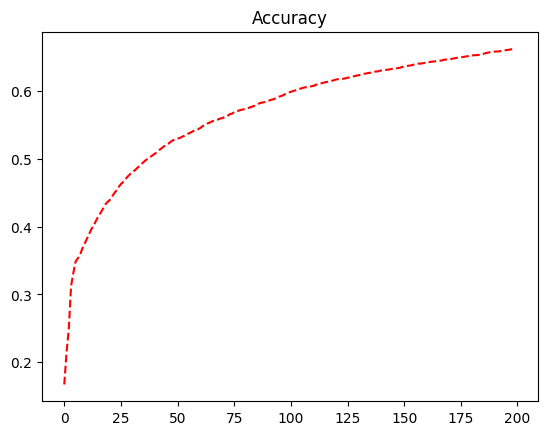

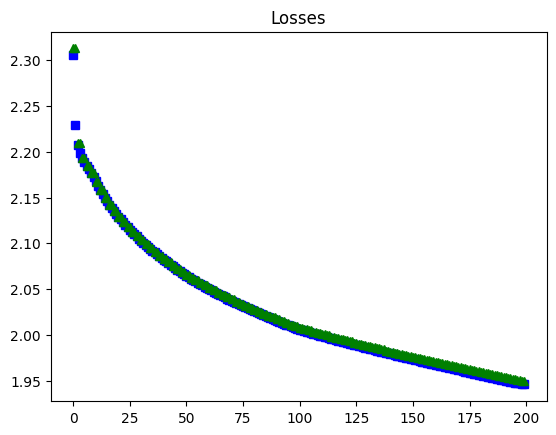

In [97]:
 ### Your code goes here ###
t = np.arange(len(accuracies))

# red dashes, blue squares and green triangles
plt.plot(t, accuracies, 'r--')
plt.title('Accuracy')
plt.show()
plt.plot(t, losses_test, 'bs', t, losses_train, 'g^')
plt.title('Losses')
plt.show()

###########################

# Compare memory usage

Hint: you can use memory-profiler library [link](https://pypi.org/project/memory-profiler/)